In [1]:
import torch
from torch.nn import Module, Parameter
from torch.autograd import Function
from theforce.radial_funcs import quadratic_cutoff as radial
from theforce.sesoap import SeSoap


def NumpySoap(cart, sumj=False):
    """ 
    cart is np.ndarray class but the output will be 
    its descriptor with torch.tensor class
    """
    return (torch.as_tensor(a) for a in
            zip(*[__soap__.derivatives(xyz, sumj=sumj) for xyz in cart]))


class _TorchSoap(Function):

    @staticmethod
    def forward(ctx, cart):
        p, q = NumpySoap(cart.detach().numpy())
        ctx.save_for_backward(q)
        return p

    @staticmethod
    def backward(ctx, grad_output):
        q, = ctx.saved_tensors
        grad = torch.einsum('ij,ij...->i...', grad_output, q)
        return grad


TorchSoap = _TorchSoap.apply


class LeastSQ(Module):

    def __init__(self, cart, soap, num_inducing):
        super(LeastSQ, self).__init__()

        global __soap__
        __soap__ = soap

        self.X, _ = NumpySoap(cart, sumj=True)

        # parameters
        self.n, self.m = self.X.size()[0], num_inducing
        _Z = cart[torch.randint(self.n, (num_inducing,))]
        if num_inducing==1: _Z = [_Z]
        self._Z = Parameter(torch.as_tensor(_Z))
        

    def forward(self):
        Z = TorchSoap(self._Z)
        loss = ((Z[:, None,] - self.X[None,])**2).sum()
        return loss

In [2]:
def _data(num_envs, rc, eps=0.05):
    import numpy as np
    sym = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0],
                    [0, 0, 1], [0, 0, -1]], dtype=np.float64)*rc/2
    #sym = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float64)*rc/2
    xyz = np.stack([sym + np.random.uniform(-rc, rc, size=sym.shape)*eps
                    for _ in range(num_envs)])
    F = np.stack([a.mean(axis=0) for a in xyz])
    return sym, xyz, F


lmax, nmax, rc = 4, 4, 3.
soap = SeSoap(lmax, nmax, radial(rc))
sym, data, _ = _data(100, rc, 0.1)
model = LeastSQ(data, soap, 1)
loss = model.forward()

In [3]:
loss.backward()

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
training = []
for i in range(2):
    for _ in range(100):
        def closure():
            global training
            optimizer.zero_grad()
            loss = model.forward()
            loss.backward() 
            training += [loss.data]
            return loss
        optimizer.step(closure)
    print((i+1)*100)

100
200


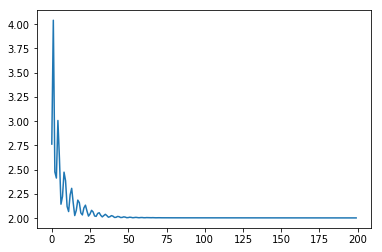

In [5]:
import pylab as plt
%matplotlib inline
plt.plot(training)

In [6]:
print(torch.einsum('ij,kj->ik', torch.tensor(sym), torch.tensor(sym)))
print(torch.einsum('ij,kj->ik', model._Z[0], model._Z[0]))

tensor([[ 2.2500, -2.2500,  0.0000,  0.0000,  0.0000,  0.0000],
        [-2.2500,  2.2500,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.2500, -2.2500,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -2.2500,  2.2500,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  2.2500, -2.2500],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -2.2500,  2.2500]],
       dtype=torch.float64)
tensor([[ 2.3159, -1.7057,  0.2056,  0.2626, -0.2910,  0.2143],
        [-1.7057,  1.4269, -0.8778,  0.4220,  0.1050, -0.1109],
        [ 0.2056, -0.8778,  3.1210, -2.6391,  0.2948, -0.0099],
        [ 0.2626,  0.4220, -2.6391,  2.4145,  0.1298, -0.4648],
        [-0.2910,  0.1050,  0.2948,  0.1298,  1.9838, -2.2766],
        [ 0.2143, -0.1109, -0.0099, -0.4648, -2.2766,  2.6571]],
       dtype=torch.float64, grad_fn=<AsStridedBackward>)
